import libraries

In [9]:
import pyodbc
import pandas as pd
import numpy as np
import joblib
import time
from prophet import Prophet

Preprocess

In [2]:
def calculate_rms(row):
    return np.sqrt(np.mean(row**2))


def preprocess_csv(file_path):
    # Read the CSV file
    df = pd.read_csv(file_path)
    df = df.drop_duplicates()

    # Drop the "water level" column
    df.drop(df.columns[25], axis=1, inplace=True)

    # Check for null or 0 values
    null_or_zero_rows = df.isnull().any(axis=1) | (df == 0).any(axis=1)

    # Remove rows with null or 0 values
    df = df[~null_or_zero_rows]

    # Add header at the first row by deleting the existing row
    header = [
        "pump_Id",
        "date",
        "timestamp",
        "Vr",
        "Vy",
        "Vb",
        "Ir",
        "Iy",
        "Ib",
        "freq",
        "power",
        "pf",
        "MNDE_temp",
        "MDE_temp",
        "PNDE_temp",
        "PDE_temp",
        "MNDE_vib",
        "MDE_vib",
        "PNDE_vib",
        "PDE_vib",
        "speed",
        "pump_eff",
        "motor_eff",
        "combined_eff",
        "water_flow",
        "head",
    ]
    df.columns = header

    df["timestamp"] = pd.to_datetime(df["date"] + " " + df["timestamp"])
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df = df.sort_values(by="timestamp")
    df["voltage_RMS"] = df[["Vr", "Vy", "Vb"]].apply(calculate_rms, axis=1)
    df["current_RMS"] = df[["Ir", "Iy", "Ib"]].apply(calculate_rms, axis=1)
    df["power"] = (np.sqrt(3) * df["voltage_RMS"] * df["current_RMS"] * df["pf"]) / 1000

    # Overwrite the original file with preprocessed data
    df.to_csv("dataset/preprocess.csv", index=False)


preprocess_csv("dataset/combined_data.csv")

prophet forecasting

11:47:44 - cmdstanpy - INFO - Chain [1] start processing
11:47:45 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\arn48\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\arn48\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
11:47:46 - cmdstanpy - INFO - Chain [1] start processing
11:47:46 - cmdstanpy - INFO - Chain [1] done processi

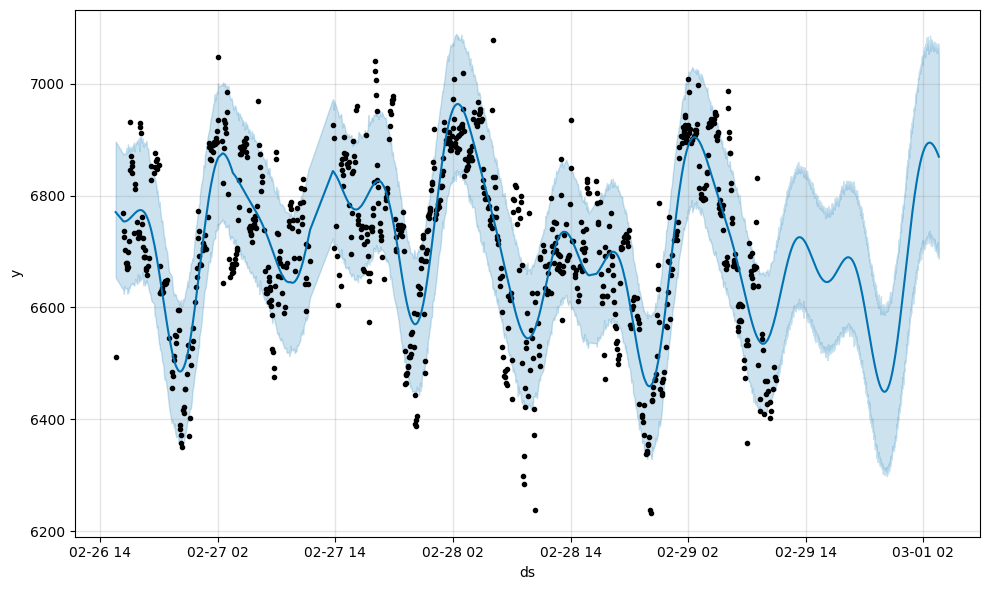

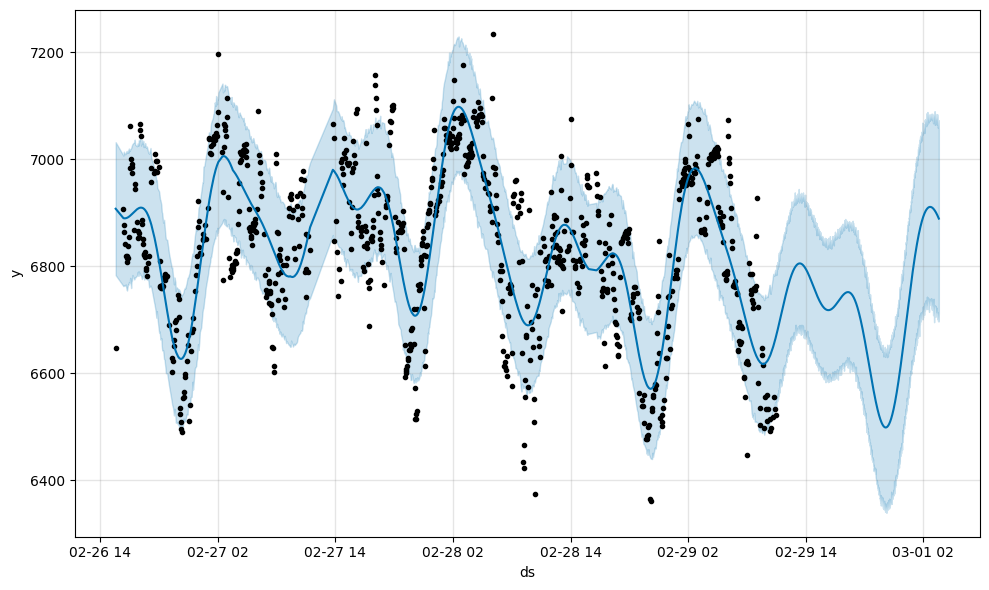

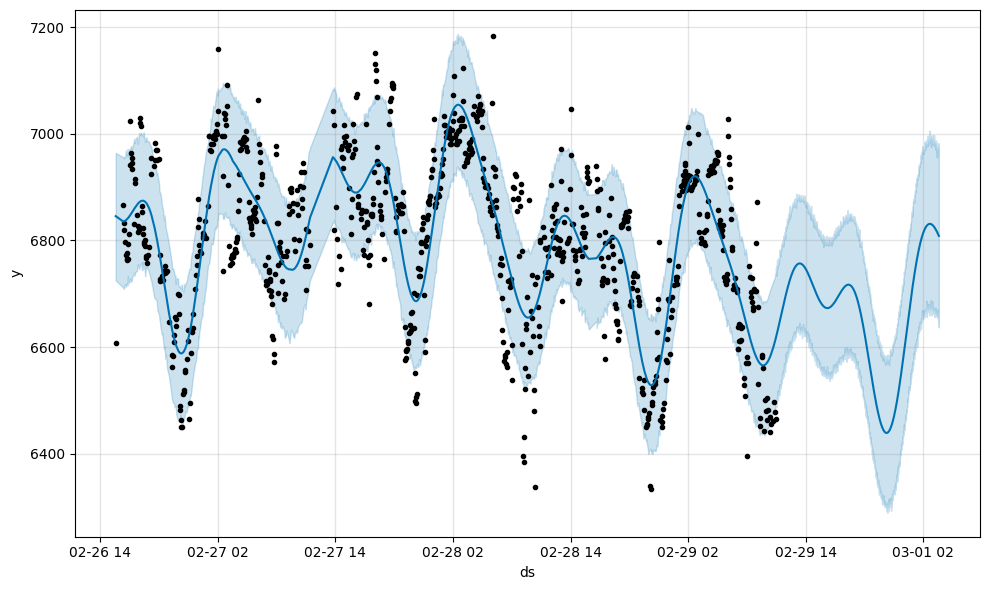

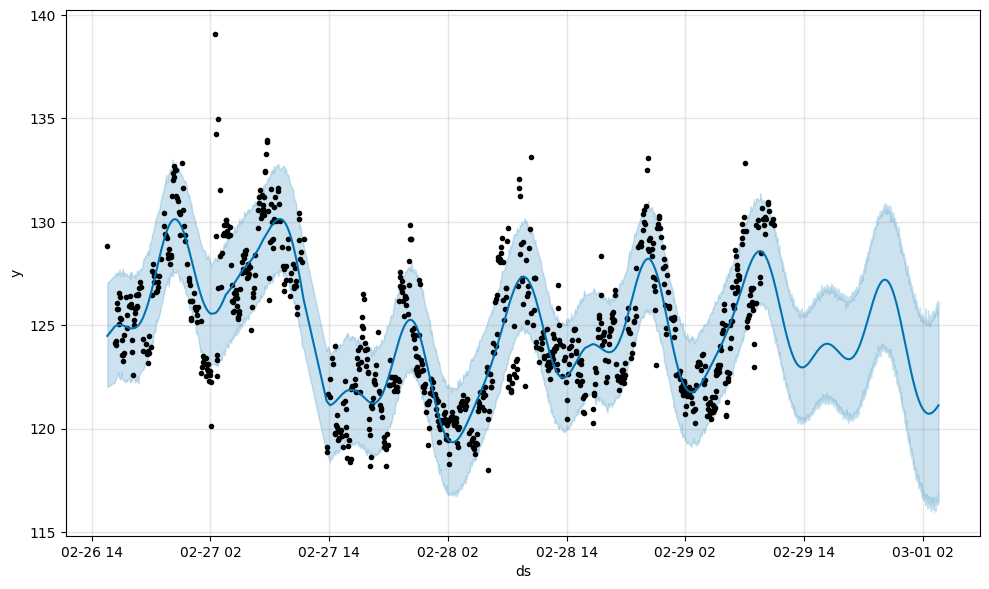

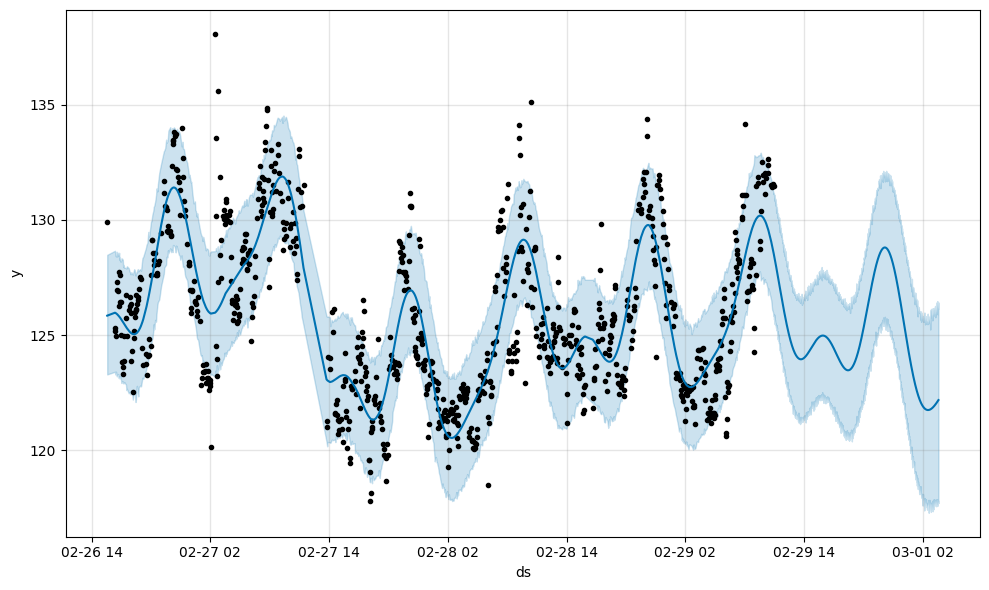

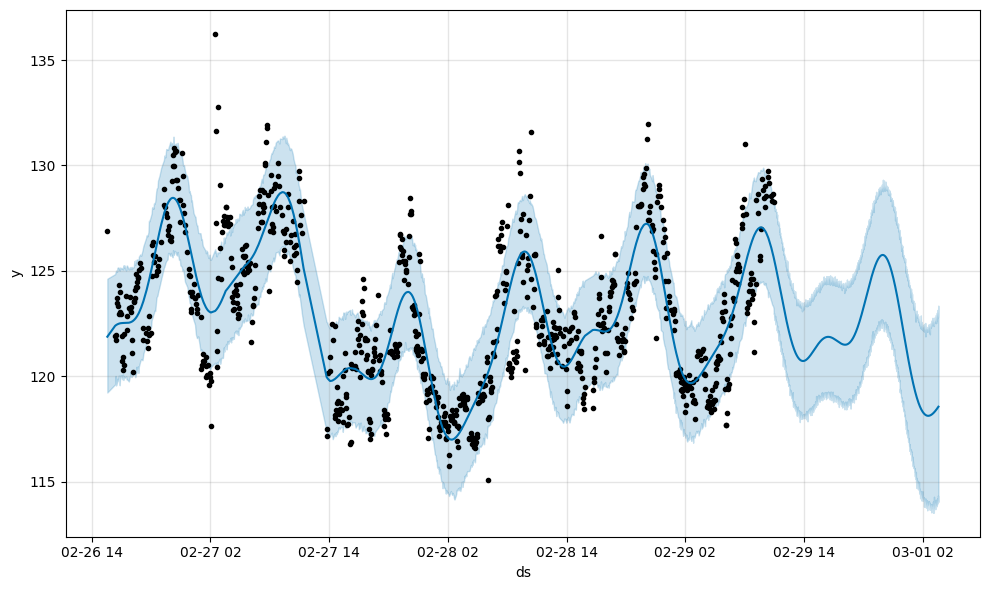

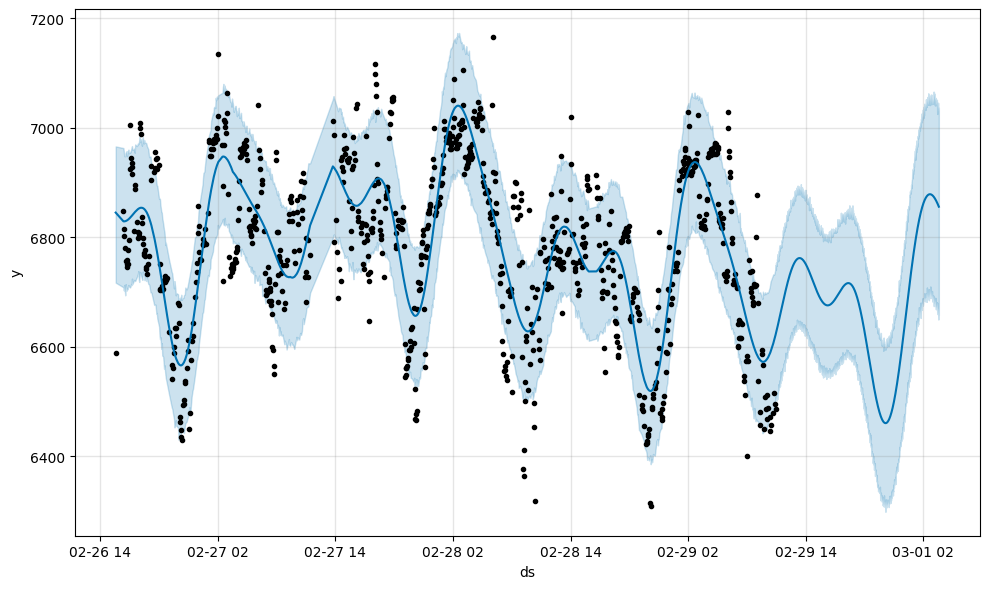

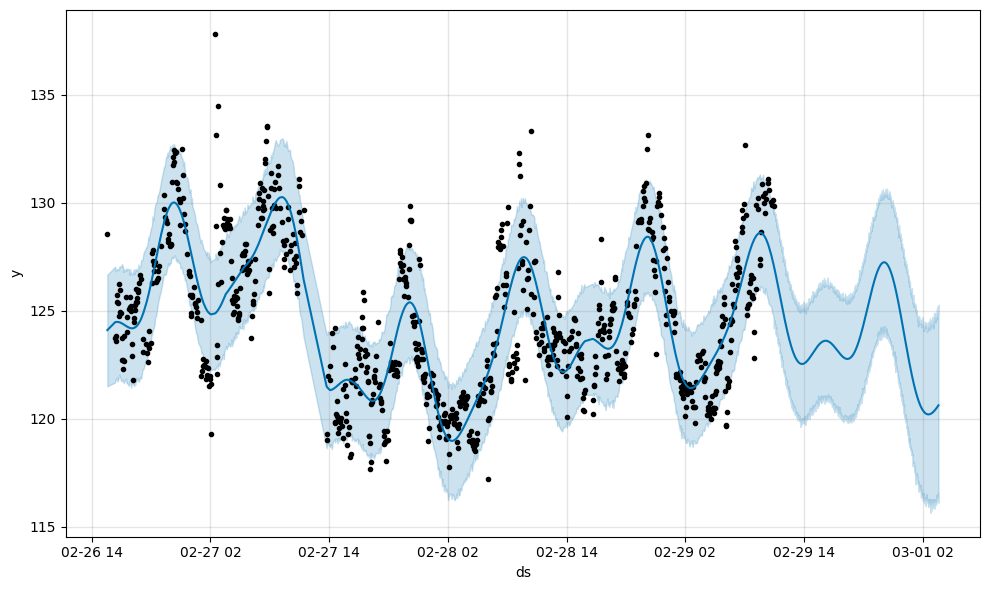

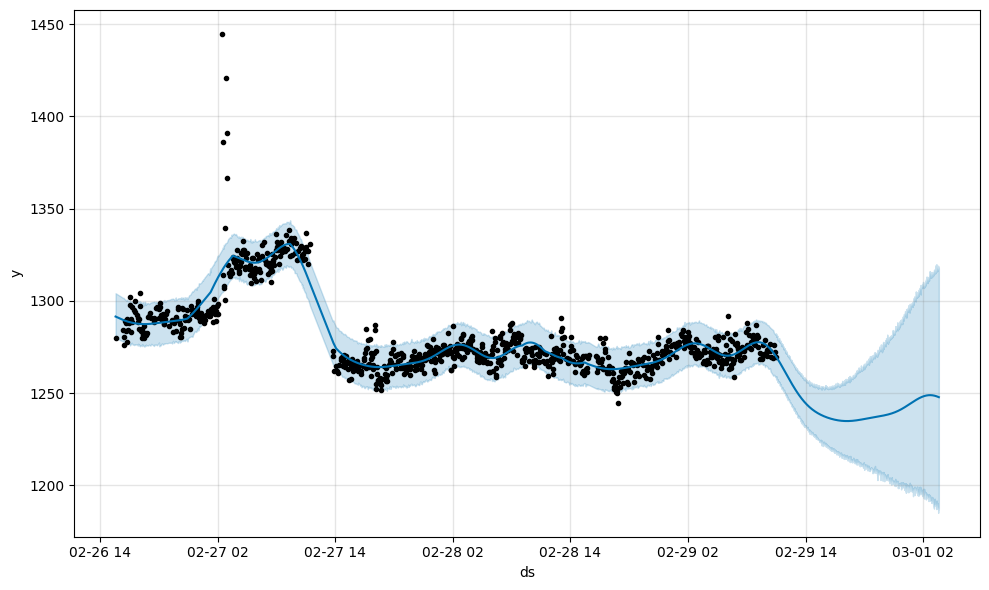

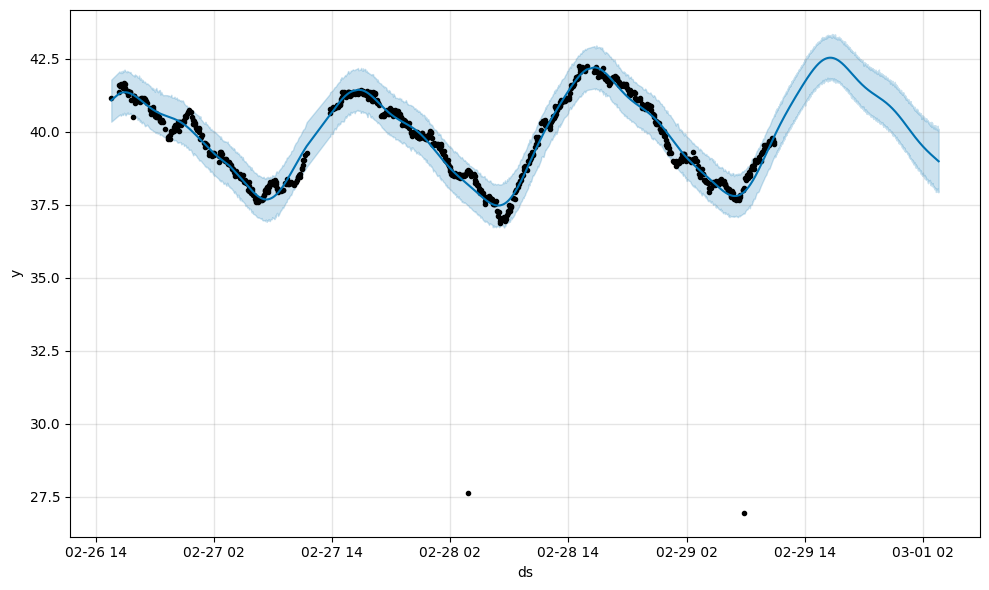

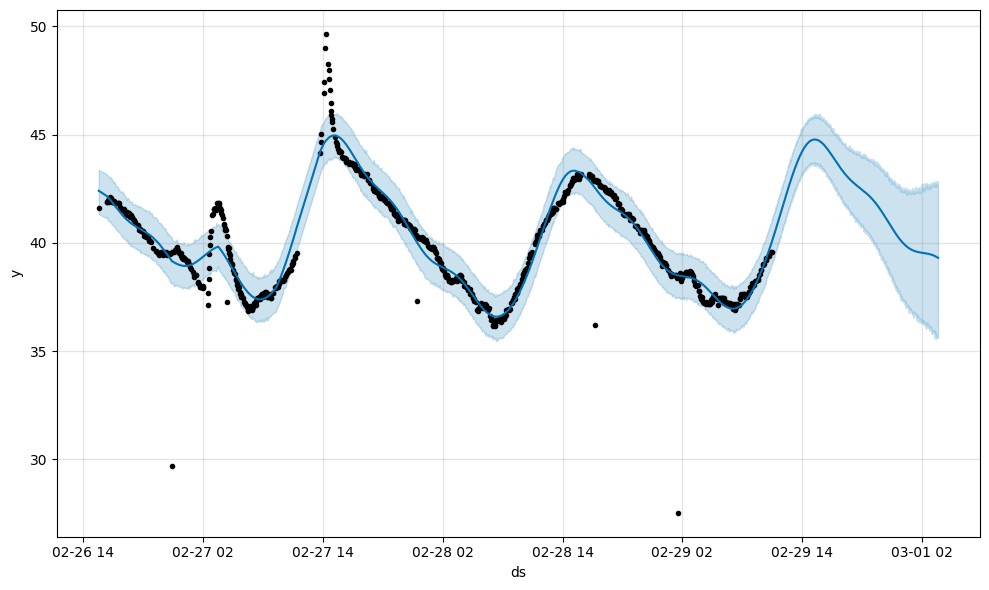

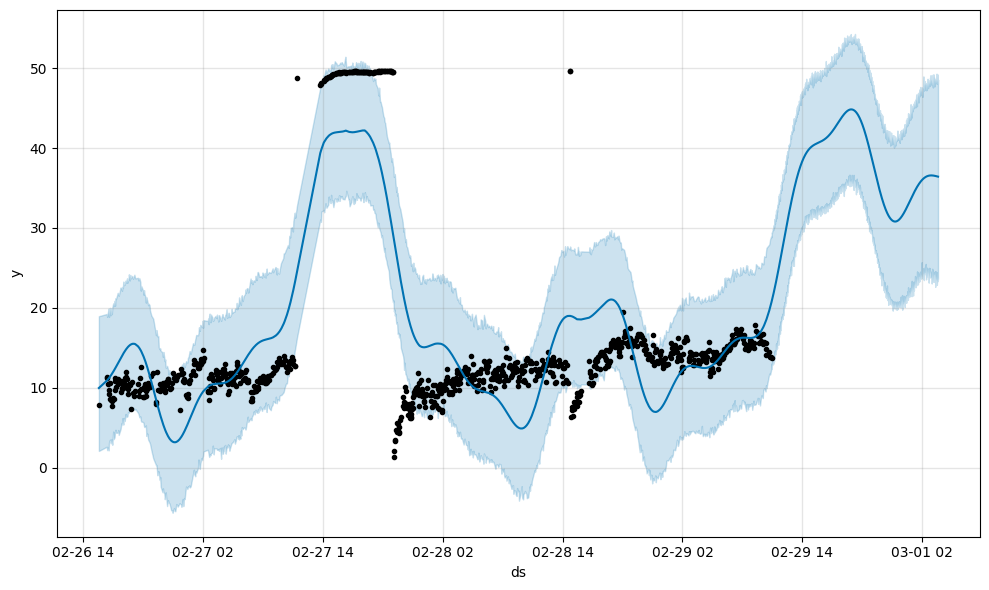

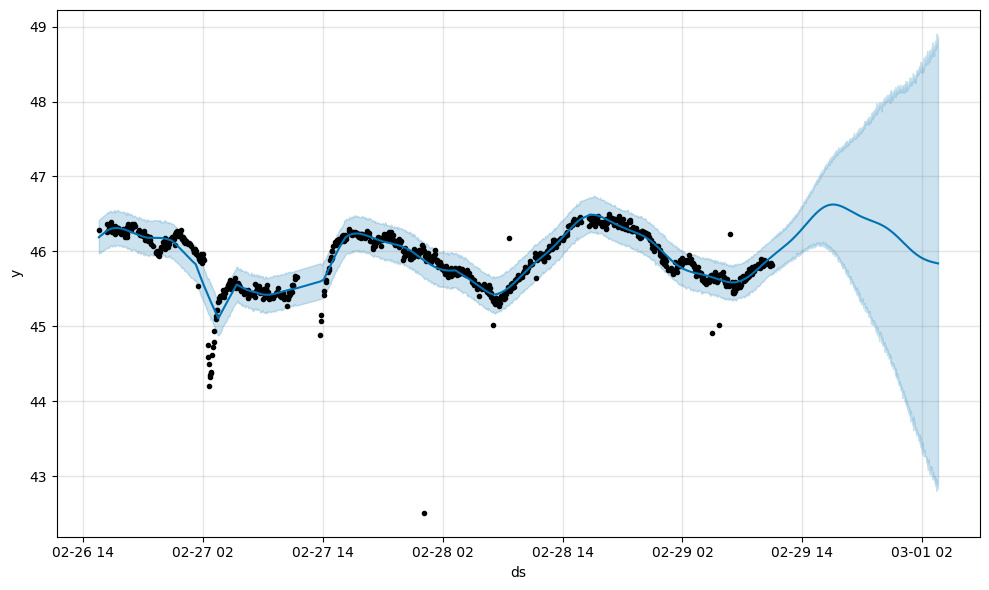

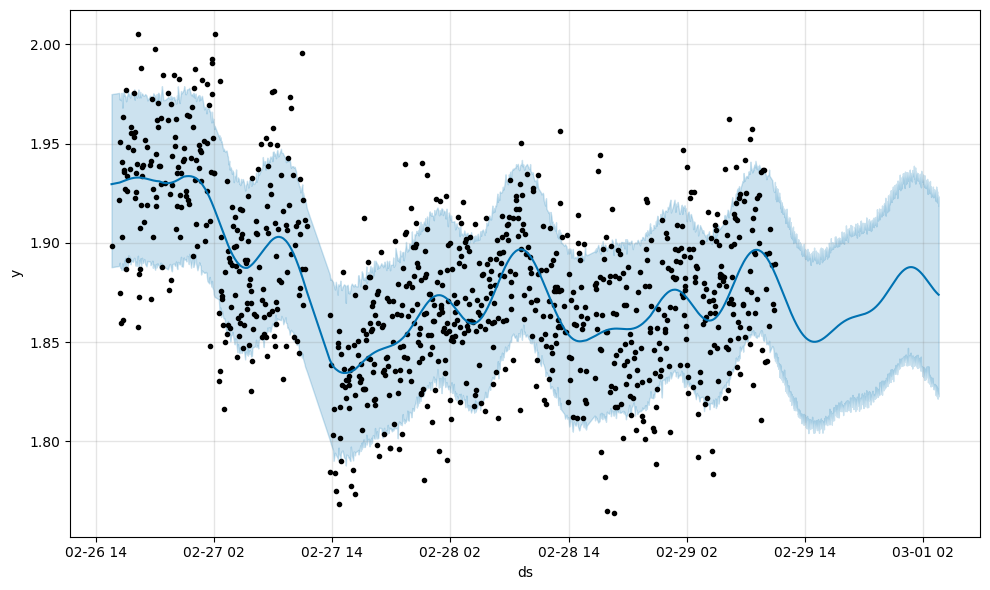

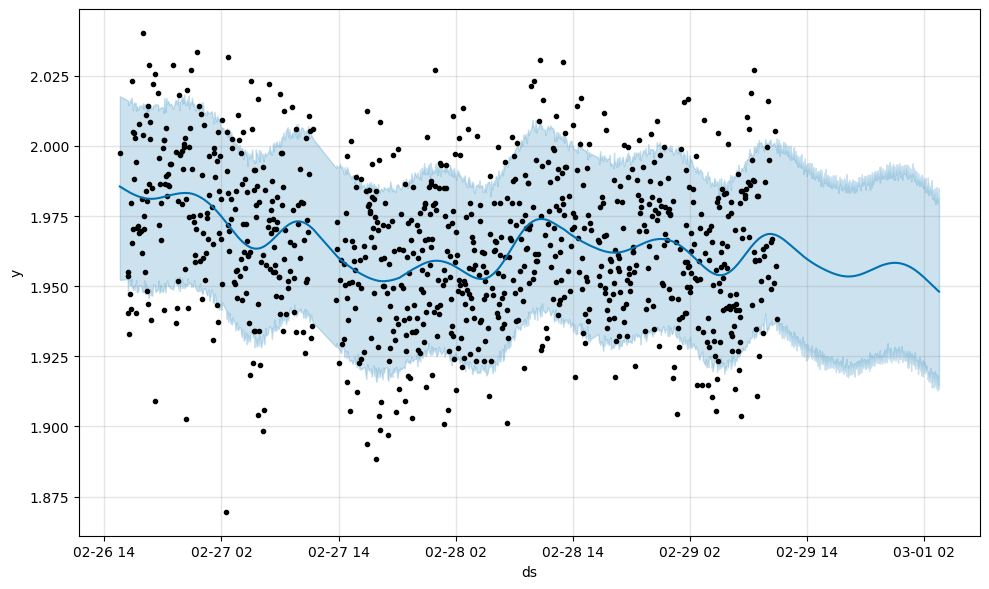

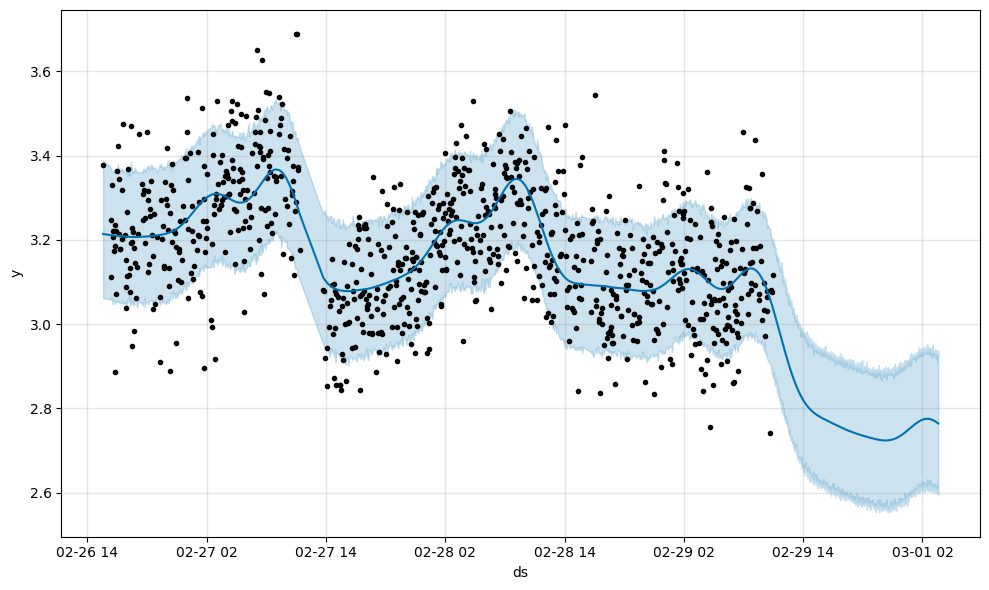

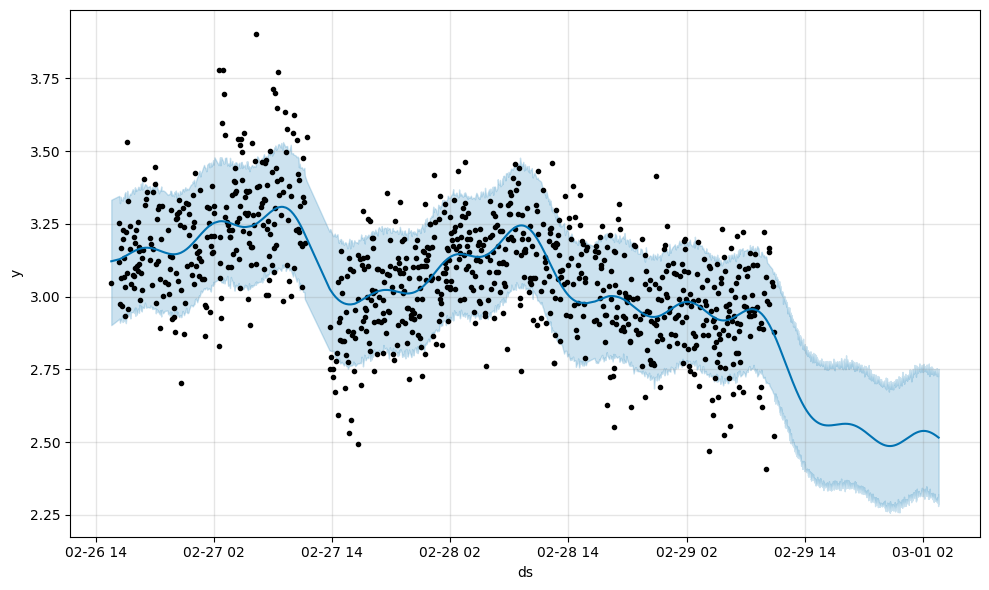

In [3]:
# Load the dataset
df = pd.read_csv("dataset/preprocess.csv")

# Convert 'Date' column to datetime
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values(by="timestamp")

# Select and rename columns as required by Prophet
columns_to_forecast = [
    "Vr",
    "Vy",
    "Vb",
    "Ir",
    "Iy",
    "Ib",
    "voltage_RMS",
    "current_RMS",
    "power",
    "MNDE_temp",
    "MDE_temp",
    "PNDE_temp",
    "PDE_temp",
    "MNDE_vib",
    "MDE_vib",
    "PNDE_vib",
    "PDE_vib",
]

forecast_data_combined = pd.DataFrame(
    columns=["timestamp"]
)  # Initialize combined dataframe

for column in columns_to_forecast:
    df_prophet = df[["timestamp", column]].copy()
    df_prophet.columns = ["ds", "y"]  # Rename columns to 'ds' (date) and 'y' (target)

    # Initialize Prophet model
    model = Prophet()

    # Fit the model
    model.fit(df_prophet)

    # Make future dataframe for forecasting
    future = model.make_future_dataframe(
        periods=1000, freq="T"
    )  # Forecast next 24 hours (adjust as needed)

    # Forecast
    forecast = model.predict(future)

    # Select relevant columns
    forecast_data = forecast[["ds", "yhat"]]
    forecast_data.columns = ["timestamp", column]  # Renaming columns
    fig = model.plot(forecast)

    # Merge forecasted data with combined dataframe
    forecast_data_combined = pd.merge(
        forecast_data_combined, forecast_data, on="timestamp", how="outer"
    )

# Save combined forecasted values to CSV
forecast_data_combined.to_csv("dataset/forecast.csv", index=False)

load classifier models

In [4]:
loaded_model_V = joblib.load("models/voltage_classifier.joblib")
loaded_model_I = joblib.load("models/current_classifier.joblib")
loaded_model_P = joblib.load("models/power_classifier.joblib")
loaded_model_Temp = joblib.load("models/temperature_classifier.joblib")
loaded_model_Vib = joblib.load("models/vibration_classifier.joblib")

predict status

In [5]:
df = pd.read_csv("dataset/forecast.csv")
features_V = ["Vr", "Vy", "Vb", "voltage_RMS"]  # (voltage)
features_I = ["Ir", "Iy", "Ib", "current_RMS"]  # (current)
features_P = ["voltage_RMS", "current_RMS", "power"]  # (power)
features_Temp = ["MNDE_temp", "MDE_temp", "PNDE_temp", "PDE_temp"]  # (temperature)
features_Vib = ["MNDE_vib", "MDE_vib", "PNDE_vib", "PDE_vib"]  # (vibration)

df["V_class"] = loaded_model_V.predict(df[features_V])
df["I_class"] = loaded_model_I.predict(df[features_I])
df["P_class"] = loaded_model_P.predict(df[features_P])
df["temp_class"] = loaded_model_Temp.predict(df[features_Temp])
df["vib_class"] = loaded_model_Vib.predict(df[features_Vib])

c:\Users\arn48\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\arn48\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\arn48\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\arn48\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning:

In [6]:
data = [
    "timestamp",
    "voltage_RMS",
    "current_RMS",
    "power",
    "MNDE_temp",
    "MDE_temp",
    "PNDE_temp",
    "PDE_temp",
    "MNDE_vib",
    "MDE_vib",
    "PNDE_vib",
    "PDE_vib",
    "V_class",
    "I_class",
    "P_class",
    "temp_class",
    "vib_class",
]

df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values(by="timestamp")
df[data].shape
df[data]

,timestamp,voltage_RMS,current_RMS,power,MNDE_temp,MDE_temp,PNDE_temp,PDE_temp,MNDE_vib,MDE_vib,PNDE_vib,PDE_vib,V_class,I_class,P_class,temp_class,vib_class
0,2024-02-26 15:34:35,6845.037106,124.096212,1291.472665,41.080166,42.408538,9.967926,46.188651,1.929551,1.985504,3.213798,3.121417,0,0,0,0,0
1,2024-02-26 16:21:55,6829.050007,124.461733,1289.553663,41.305595,42.172023,10.861636,46.275050,1.930301,1.983816,3.210940,3.127800,0,0,0,0,0
2,2024-02-26 16:24:39,6828.971892,124.467749,1289.462595,41.313140,42.150631,10.927706,46.278549,1.930380,1.983727,3.210821,3.128475,0,0,0,0,0
3,2024-02-26 16:27:28,6828.981972,124.472292,1289.370811,41.320268,42.127940,10.997997,46.281972,1.930465,1.983636,3.210701,3.129198,0,0,0,0,0
4,2024-02-26 16:33:02,6829.262611,124.476488,1289.195508,41.332428,42.081320,11.143633,46.288190,1.930637,1.983459,3.210468,3.130698,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1890,2024-03-01 03:31:18,6858.682181,120.569293,1247.899885,39.010223,39.332898,36.440634,45.841390,1.874160,1.948265,2.765198,2.517347,0,1,0,0,0
1891,2024-03-01 03:32:18,6857.973546,120.580573,1247.863068,39.005280,39.328267,36.435241,45.840899,1.874083,1.948215,2.764897,2.516915,0,1,0,0,0
1892,2024-03-01 03:33:18,6857.256293,120.591948,1247.825666,39.000336,39.323572,36.429850,45.840410,1.874007,1.948165,2.764593,2.516482,0,1,0,0,0
1893,2024-03-01 03:34:18,6856.530619,120.603415,1247.787689,38.995391,39.318813,36.424468,45.839922,1.873932,1.948115,2.764285,2.516046,0,1,0,0,0


In [7]:
con = pyodbc.connect(
    "Driver={SQL Server};"
    "Server=Nishanth\SQLEXPRESS;"
    "Database=Pump_data;"
    "Trusted_Connection=yes;"
)

cursor = con.cursor()

In [8]:
for row in df[data].itertuples():
    cursor.execute(
        """INSERT INTO Pump_data.dbo.pump_status (date_time,  voltage_forecast, current_forecast, power_forecast, MNDE_temp_forecast, MDE_temp_forecast, PNDE_temp_forecast, PDE_temp_forecast, MNDE_vib_forecast, MDE_vib_forecast, PNDE_vib_forecast, PDE_vib_forecast, V_class_forecast, I_class_forecast, P_class_forecast, temp_class_forecast, vib_class_forecast) VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)""",
        row.timestamp,
        row.voltage_RMS,
        row.current_RMS,
        row.power,
        row.MNDE_temp,
        row.MDE_temp,
        row.PNDE_temp,
        row.PDE_temp,
        row.MNDE_vib,
        row.MDE_vib,
        row.PNDE_vib,
        row.PDE_vib,
        row.V_class,
        row.I_class,
        row.P_class,
        row.temp_class,
        row.vib_class,
    )
    con.commit()
    time.sleep(0.8)

KeyboardInterrupt: 